In [1]:
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd
from mxnet import nd
import numpy as np
import pickle as p
import mxnet as mx
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
route = '/home/sinyer/Python/data'
train_num = 50000
test_num = 10000
batch_size = 256
def load_CIFAR_batch(filename):
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32,32).astype("float")
        Y = np.array(Y)
        return X, Y
def load_CIFAR_Labels(filename):
    with open(filename, 'rb') as f:
        label_names = p.load(f, encoding='latin1')
        names = label_names['label_names']
        return names
label_names = load_CIFAR_Labels(route + "/cifar-10-batches-py/batches.meta")
img_X1, img_Y1 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_1")
img_X2, img_Y2 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_2")
img_X3, img_Y3 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_3")
img_X4, img_Y4 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_4")
img_X5, img_Y5 = load_CIFAR_batch(route + "/cifar-10-batches-py/data_batch_5")
test_pic, test_label = load_CIFAR_batch(route + "/cifar-10-batches-py/test_batch")
train_pic = np.concatenate((img_X1, img_X2, img_X3, img_X4, img_X5))
train_label = np.concatenate((img_Y1, img_Y2, img_Y3, img_Y4, img_Y5))
X = train_pic[:train_num,:].astype('float32')/255
y = train_label[:train_num].astype('float32')
X_ = test_pic[:test_num,:].astype('float32')/255
y_ = test_label[:test_num].astype('float32')
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
for i in range(3):
    X[:,:,:,i] = (X[:,:,:,i] - mean[i]) / std[i]
    X_[:,:,:,i] = (X_[:,:,:,i] - mean[i]) / std[i]
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_, y_), batch_size, shuffle=False)

In [3]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

def relu(x):
    return nd.maximum(x, 0)
def net(x):
    x = x.reshape((-1, inp))
    h1 = relu(nd.dot(x, w1) + b1)
    output = nd.dot(h1, w2) + b2
    return output

In [4]:
n, inp, h, out = 50000, 3072, 128, 10
weight_scale = .01

w1 = nd.random_normal(shape=(inp, h), scale=weight_scale, ctx=ctx)
b1 = nd.zeros(h, ctx=ctx)
w2 = nd.random_normal(shape=(h, out), scale=weight_scale, ctx=ctx)
b2 = nd.zeros(out, ctx=ctx)

params = [w1, b1, w2, b2]
for param in params:
    param.attach_grad()

sce = gluon.loss.SoftmaxCrossEntropyLoss()

Epoch 0, Loss: 2.222972, Train acc 0.187803, Test acc 0.226855
Epoch 20, Loss: 1.626444, Train acc 0.430230, Test acc 0.430469
Epoch 40, Loss: 1.471126, Train acc 0.486775, Test acc 0.467090
Epoch 60, Loss: 1.377336, Train acc 0.522106, Test acc 0.489648
Epoch 80, Loss: 1.305113, Train acc 0.545153, Test acc 0.494922
Epoch 100, Loss: 1.247539, Train acc 0.567582, Test acc 0.505859
Epoch 120, Loss: 1.195918, Train acc 0.584917, Test acc 0.512109
Epoch 140, Loss: 1.162263, Train acc 0.600482, Test acc 0.514746
Epoch 160, Loss: 1.155332, Train acc 0.603197, Test acc 0.512305
Epoch 180, Loss: 1.151241, Train acc 0.604277, Test acc 0.514844


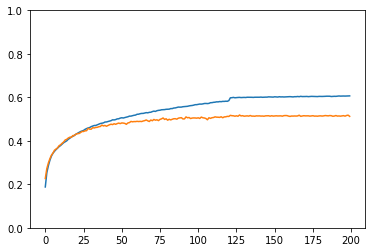

In [5]:
lr = 0.01 / batch_size
epochs = 200

a = []
b = []
for epoch in range(epochs):
    if epoch > 120:
        lr = 0.001 / batch_size
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = sce(output, label)
        loss.backward()
        for param in params:
            param[:] = param - lr * param.grad
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    a.append(train_acc/len(train_data))
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%20 == 0:
        print("Epoch %d, Loss: %f, Train acc %f, Test acc %f" % (epoch, train_loss/len(train_data), train_acc/len(train_data), test_acc))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()